In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')
import scorecardpy as sc
import pprint

In [2]:
# read datasets
application_data = pd.read_csv('IS453 Group Assignment - Application Data.csv')
bureau_data = pd.read_csv('IS453 Group Assignment - Bureau Data.csv')

In [3]:
# filter dataset to find single parent
subset_a = application_data[
    ((application_data['NAME_FAMILY_STATUS'] == 'Single / not married') |
    (application_data['NAME_FAMILY_STATUS'] == 'Widow') |
    (application_data['NAME_FAMILY_STATUS'] == 'Separated')) &
    (application_data['CNT_CHILDREN'] >= 1)
]

subset_a.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
19,100023,0,Cash loans,F,N,Y,1,90000.0,544491.0,17563.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
58,100069,0,Cash loans,M,Y,Y,1,360000.0,640458.0,27265.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
72,100084,0,Cash loans,M,N,Y,2,225000.0,495351.0,26140.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
74,100086,0,Cash loans,F,N,Y,1,135000.0,675000.0,21775.5,...,0,0,0,0,0.0,0.0,0.0,1.0,4.0,2.0
87,100102,0,Cash loans,F,N,N,1,126000.0,327024.0,10264.5,...,0,0,0,0,0.0,0.0,0.0,6.0,0.0,0.0


In [4]:
# feature selection
selected_features = ['SK_ID_CURR','TARGET','AMT_INCOME_TOTAL','AMT_CREDIT','DAYS_BIRTH','DAYS_EMPLOYED',
                     'NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE','OCCUPATION_TYPE']

final_df = subset_a[selected_features]
final_df.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,OCCUPATION_TYPE
19,100023,0,90000.0,544491.0,-11348,-2038,Higher education,House / apartment,Core staff
58,100069,0,360000.0,640458.0,-14186,-1743,Secondary / secondary special,House / apartment,Laborers
72,100084,0,225000.0,495351.0,-14860,-1156,Secondary / secondary special,House / apartment,Laborers
74,100086,0,135000.0,675000.0,-14264,-2492,Higher education,House / apartment,Laborers
87,100102,0,126000.0,327024.0,-14321,-192,Secondary / secondary special,House / apartment,Laborers


In [5]:
# fetaure extraction
final_df['DEBT_INC'] = final_df['AMT_CREDIT'] / final_df['AMT_INCOME_TOTAL']
final_df.drop(['AMT_CREDIT', 'AMT_INCOME_TOTAL'], axis=1, inplace=True)
final_df.head()

,SK_ID_CURR,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,OCCUPATION_TYPE,DEBT_INC
19,100023,0,-11348,-2038,Higher education,House / apartment,Core staff,6.049900
58,100069,0,-14186,-1743,Secondary / secondary special,House / apartment,Laborers,1.779050
72,100084,0,-14860,-1156,Secondary / secondary special,House / apartment,Laborers,2.201560
74,100086,0,-14264,-2492,Higher education,House / apartment,Laborers,5.000000
87,100102,0,-14321,-192,Secondary / secondary special,House / apartment,Laborers,2.595429


In [6]:
# feature selection
selected_features = ['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']

df_b = bureau_data[selected_features]
df_b.head()

,SK_ID_CURR,AMT_CREDIT_SUM_OVERDUE
0,215354,0.0
1,215354,0.0
2,215354,0.0
3,215354,0.0
4,215354,0.0


In [7]:
# calculate sum of AMT_CREDIT_SUM_OVERDUE for each unqiue applicant
df_b['AMT_CREDIT_SUM_OVERDUE_TOTAL'] = df_b.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].transform('sum')
df_b.drop_duplicates(subset=['SK_ID_CURR'], keep='first', inplace=True)
df_b.head()

,SK_ID_CURR,AMT_CREDIT_SUM_OVERDUE,AMT_CREDIT_SUM_OVERDUE_TOTAL
0,215354,0.0,0.0
7,162297,0.0,0.0
13,402440,0.0,0.0
14,238881,0.0,0.0
21,222183,0.0,0.0


In [8]:
# merge datasets
final_df = final_df.merge(df_b, on='SK_ID_CURR', how='inner')

final_df.head()

,SK_ID_CURR,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,OCCUPATION_TYPE,DEBT_INC,AMT_CREDIT_SUM_OVERDUE,AMT_CREDIT_SUM_OVERDUE_TOTAL
0,100023,0,-11348,-2038,Higher education,House / apartment,Core staff,6.049900,0.0,0.0
1,100069,0,-14186,-1743,Secondary / secondary special,House / apartment,Laborers,1.779050,0.0,0.0
2,100084,0,-14860,-1156,Secondary / secondary special,House / apartment,Laborers,2.201560,0.0,0.0
3,100086,0,-14264,-2492,Higher education,House / apartment,Laborers,5.000000,0.0,0.0
4,100102,0,-14321,-192,Secondary / secondary special,House / apartment,Laborers,2.595429,0.0,0.0


In [9]:
final_df.drop(['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE'], axis=1, inplace=True)

In [10]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11616 entries, 0 to 11615
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TARGET                        11616 non-null  int64  
 1   DAYS_BIRTH                    11616 non-null  int64  
 2   DAYS_EMPLOYED                 11616 non-null  int64  
 3   NAME_EDUCATION_TYPE           11616 non-null  object 
 4   NAME_HOUSING_TYPE             11616 non-null  object 
 5   OCCUPATION_TYPE               9421 non-null   object 
 6   DEBT_INC                      11616 non-null  float64
 7   AMT_CREDIT_SUM_OVERDUE_TOTAL  11616 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 726.1+ KB


In [11]:
final_df['AMT_CREDIT_SUM_OVERDUE_TOTAL'].value_counts()

AMT_CREDIT_SUM_OVERDUE_TOTAL
0.00        11471
4.50            5
13.50           4
27.00           4
36.00           4
            ...  
49.50           1
40.50           1
130.50          1
526.50          1
30388.95        1
Name: count, Length: 123, dtype: int64

In [12]:
# automatically calculate bin ranges 
bins = sc.woebin(final_df, y='TARGET')

# make it easy to read the bins
for variables , bindetails in bins.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

[INFO] creating woe binning ...


/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:136: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_sv = pd.merge(
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:136: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_sv = pd.merge(
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tot

/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:442: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binning_1bst_brk = binning_1bst_brk.groupby(['variable', 'bstbin'], group_keys=False)\
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:442: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_1bst_brk = binning_1bst_brk.groupby(['variable', 'bstbin'], group_keys=False)\
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:442: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a

/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_iv_all_brks = pd.melt(
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_iv_all_brks = pd.melt(
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" in

OCCUPATION_TYPE  : 


/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_iv_all_brks = pd.melt(
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_iv_all_brks = pd.melt(
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:442: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence th

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OCCUPATION_TYPE,missing,2195,0.188963,2001,194,0.088383,-0.053664,0.000532,0.108028,missing,True
1,OCCUPATION_TYPE,"IT staff%,%Secretaries%,%Realty agents%,%Accou...",2491,0.214446,2355,136,0.054597,-0.571761,0.055642,0.108028,"IT staff%,%Secretaries%,%Realty agents%,%Accou...",False
2,OCCUPATION_TYPE,"High skill tech staff%,%Managers%,%Private ser...",1577,0.135761,1457,120,0.076094,-0.216763,0.005841,0.108028,"High skill tech staff%,%Managers%,%Private ser...",False
3,OCCUPATION_TYPE,"Sales staff%,%Waiters/barmen staff%,%Cleaning ...",4522,0.389291,4022,500,0.110571,0.194954,0.016017,0.108028,"Sales staff%,%Waiters/barmen staff%,%Cleaning ...",False
4,OCCUPATION_TYPE,"Cooking staff%,%Drivers%,%Low-skill Laborers",831,0.071539,703,128,0.154031,0.576554,0.029997,0.108028,"Cooking staff%,%Drivers%,%Low-skill Laborers",False


----------------------------------------------------------------------------------------------------
NAME_HOUSING_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_HOUSING_TYPE,"Office apartment%,%House / apartment%,%Co-op a...",9780,0.841942,8925,855,0.087423,-0.065630,0.003531,0.021674,"Office apartment%,%House / apartment%,%Co-op a...",False
1,NAME_HOUSING_TYPE,With parents,1022,0.087982,908,114,0.111546,0.204834,0.004012,0.021674,With parents,False
2,NAME_HOUSING_TYPE,"Municipal apartment%,%Rented apartment",814,0.070076,705,109,0.133907,0.413030,0.014131,0.021674,"Municipal apartment%,%Rented apartment",False


----------------------------------------------------------------------------------------------------
DAYS_BIRTH  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_BIRTH,"[-inf,-14500.0)",4618,0.397555,4279,339,0.073408,-0.255594,0.023408,0.047025,-14500.0,False
1,DAYS_BIRTH,"[-14500.0,-13500.0)",1715,0.147641,1563,152,0.088630,-0.050602,0.000370,0.047025,-13500.0,False
2,DAYS_BIRTH,"[-13500.0,-11000.0)",3560,0.306474,3185,375,0.105337,0.140599,0.006415,0.047025,-11000.0,False
3,DAYS_BIRTH,"[-11000.0,inf)",1723,0.148330,1511,212,0.123041,0.315940,0.016832,0.047025,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT_SUM_OVERDUE_TOTAL  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT_SUM_OVERDUE_TOTAL,"[-inf,inf)",11616,1.0,10538,1078,0.092803,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
DEBT_INC  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBT_INC,"[-inf,1.0)",724,0.062328,686,38,0.052486,-0.613411,0.018309,0.031878,1.0,False
1,DEBT_INC,"[1.0,1.6)",1594,0.137225,1464,130,0.081556,-0.141513,0.002594,0.031878,1.6,False
2,DEBT_INC,"[1.6,3.4000000000000004)",5127,0.441374,4629,498,0.097133,0.050384,0.001144,0.031878,3.4000000000000004,False
3,DEBT_INC,"[3.4000000000000004,6.2)",3185,0.274191,2848,337,0.105808,0.145591,0.006167,0.031878,6.2,False
4,DEBT_INC,"[6.2,inf)",986,0.084883,911,75,0.076065,-0.217174,0.003665,0.031878,inf,False


----------------------------------------------------------------------------------------------------
DAYS_EMPLOYED  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_EMPLOYED,"[-inf,-3200.0)",2456,0.211433,2318,138,0.056189,-0.541326,0.049775,0.081526,-3200.0,False
1,DAYS_EMPLOYED,"[-3200.0,-2600.0)",865,0.074466,798,67,0.077457,-0.197536,0.002681,0.081526,-2600.0,False
2,DAYS_EMPLOYED,"[-2600.0,-1400.0)",2540,0.218664,2321,219,0.086220,-0.080801,0.001381,0.081526,-1400.0,False
3,DAYS_EMPLOYED,"[-1400.0,inf)",5755,0.495437,5101,654,0.113640,0.225796,0.027687,0.081526,inf,False


----------------------------------------------------------------------------------------------------
NAME_EDUCATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_EDUCATION_TYPE,Higher education,3353,0.288654,3174,179,0.053385,-0.595482,0.080478,0.104373,Higher education,False
1,NAME_EDUCATION_TYPE,"Incomplete higher%,%Secondary / secondary spec...",8263,0.711346,7364,899,0.108798,0.176805,0.023895,0.104373,"Incomplete higher%,%Secondary / secondary spec...",False


----------------------------------------------------------------------------------------------------


{'OCCUPATION_TYPE': <Figure size 640x480 with 2 Axes>,
 'NAME_HOUSING_TYPE': <Figure size 640x480 with 2 Axes>,
 'DAYS_BIRTH': <Figure size 640x480 with 2 Axes>,
 'AMT_CREDIT_SUM_OVERDUE_TOTAL': <Figure size 640x480 with 2 Axes>,
 'DEBT_INC': <Figure size 640x480 with 2 Axes>,
 'DAYS_EMPLOYED': <Figure size 640x480 with 2 Axes>,
 'NAME_EDUCATION_TYPE': <Figure size 640x480 with 2 Axes>}

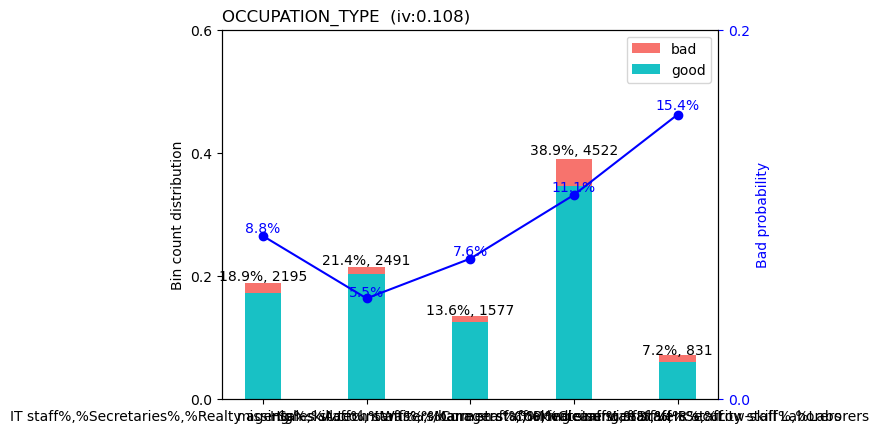

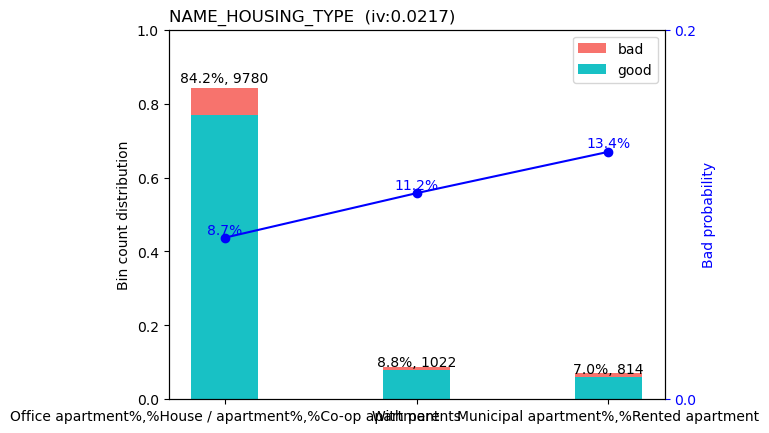

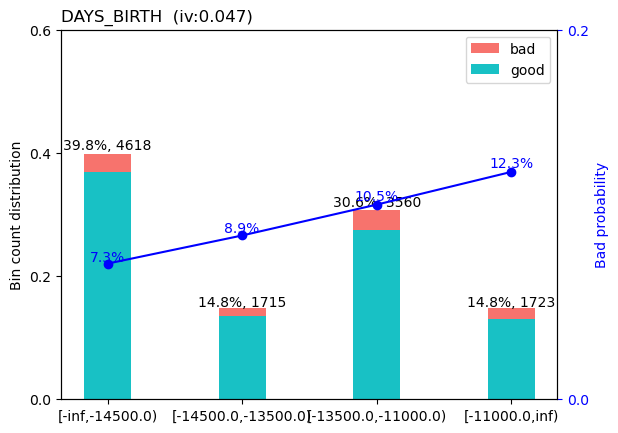

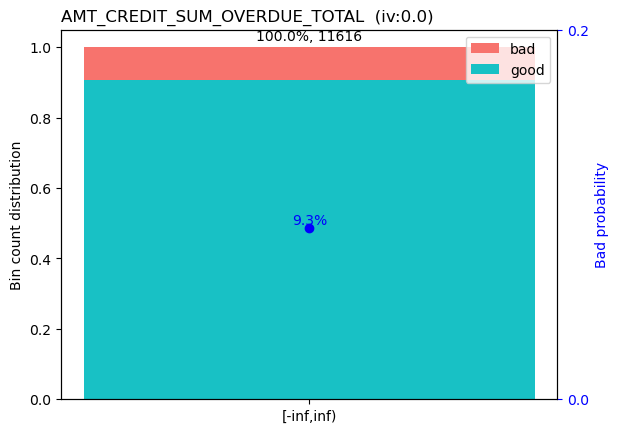

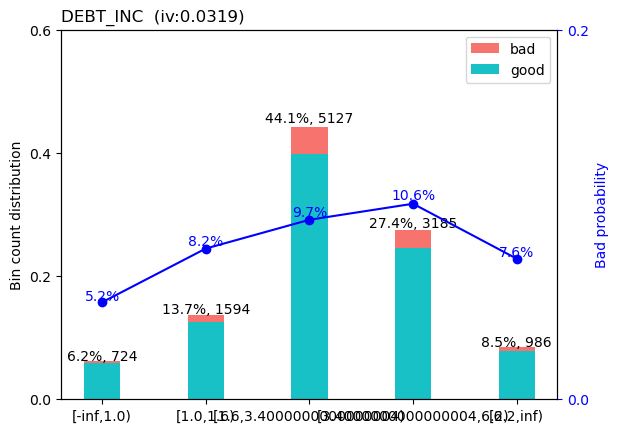

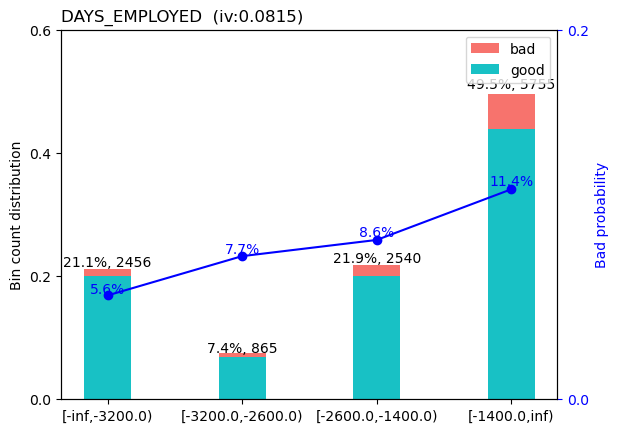

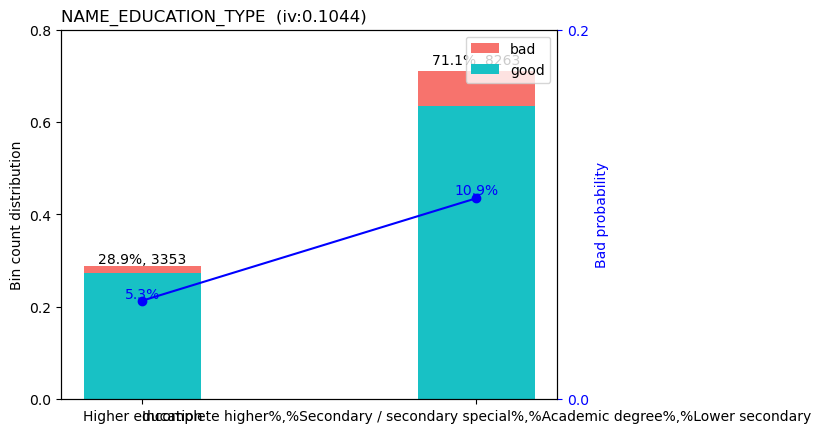

In [13]:
# plot bins
sc.woebin_plot(bins)

[INFO] creating woe binning ...


/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:136: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_sv = pd.merge(
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:136: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_sv = pd.merge(
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tot

/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_iv_all_brks = pd.melt(
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_iv_all_brks = pd.melt(
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence th

/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_iv_all_brks = pd.melt(
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_iv_all_brks = pd.melt(
/Users/qinxuan/opt/anaconda3/lib/python3.9/site-packages/scorecardpy/woebin.py:442: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence th

{'DEBT_INC': <Figure size 640x480 with 2 Axes>}

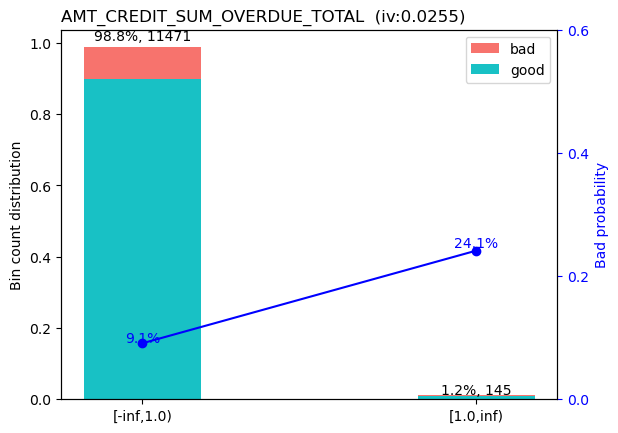

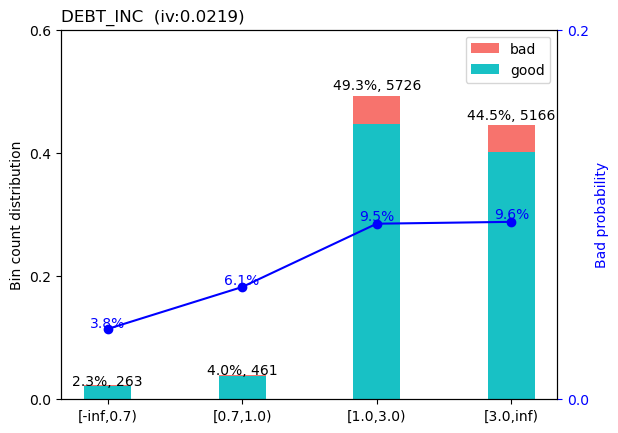

In [14]:
# adjust bin ranges for monotonicity
breaks_adj_combined = {
    'AMT_CREDIT_SUM_OVERDUE_TOTAL': [1, 3],
    'DEBT_INC': [0.7, 1, 3]
}

bins2 = sc.woebin(final_df, y='TARGET', breaks_list=breaks_adj_combined)

sc.woebin_plot(bins2['AMT_CREDIT_SUM_OVERDUE_TOTAL'])
sc.woebin_plot(bins2['DEBT_INC'])

In [15]:
# split into train and test sets
train, test = sc.split_df(final_df, 'TARGET', ratio=0.7).values()
print(train.shape)
print(test.shape)

(8132, 8)
(3484, 8)


In [16]:
# woe encoding
train_woe = sc.woebin_ply(train, bins2)
test_woe = sc.woebin_ply(test, bins2)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,TARGET,OCCUPATION_TYPE_woe,NAME_HOUSING_TYPE_woe,DAYS_BIRTH_woe,AMT_CREDIT_SUM_OVERDUE_TOTAL_woe,DEBT_INC_woe,DAYS_EMPLOYED_woe,NAME_EDUCATION_TYPE_woe
0,0,-0.571761,-0.06563,0.140599,-0.022513,0.037542,-0.080801,-0.595482
3,0,0.194954,-0.06563,-0.050602,-0.022513,0.037542,-0.080801,-0.595482
4,0,0.194954,-0.06563,-0.050602,-0.022513,0.025883,0.225796,0.176805
5,1,0.194954,-0.06563,0.315940,-0.022513,0.037542,0.225796,0.176805
7,0,-0.571761,-0.06563,-0.050602,-0.022513,0.025883,-0.541326,0.176805
...,...,...,...,...,...,...,...,...
11609,0,-0.571761,-0.06563,-0.050602,-0.022513,-0.950924,-0.080801,0.176805
11610,0,-0.053664,-0.06563,-0.255594,-0.022513,0.037542,-0.541326,-0.595482
11611,0,-0.571761,-0.06563,0.315940,-0.022513,0.025883,0.225796,0.176805
11612,0,0.194954,0.41303,-0.255594,-0.022513,0.025883,-0.080801,0.176805


In [17]:
# create the X, y parts of data for train and test
y_train = train_woe.loc[:,'TARGET']
X_train = train_woe.loc[:,train_woe.columns != 'TARGET']
y_test = test_woe.loc[:,'TARGET']
X_test = test_woe.loc[:,train_woe.columns != 'TARGET']

# create a logistic regression model
lr = LogisticRegression(class_weight = "balanced")
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[[0.75325129 0.8353544  0.96253943 0.91930566 1.00800706 0.69689352
  0.7998344 ]]
[-0.01100983]


In [18]:
# generate scorecard
card = sc.scorecard(bins2, lr, X_train.columns, points0 = 600, odds0 = 1/20, pdo = 20, basepoints_eq0 = True)

pprint.pprint(card)

{'AMT_CREDIT_SUM_OVERDUE_TOTAL':                         variable         bin  points
12  AMT_CREDIT_SUM_OVERDUE_TOTAL  [-inf,1.0)    74.0
13  AMT_CREDIT_SUM_OVERDUE_TOTAL   [1.0,inf)    43.0,
 'DAYS_BIRTH':       variable                  bin  points
8   DAYS_BIRTH      [-inf,-14500.0)    81.0
9   DAYS_BIRTH  [-14500.0,-13500.0)    75.0
10  DAYS_BIRTH  [-13500.0,-11000.0)    70.0
11  DAYS_BIRTH       [-11000.0,inf)    65.0,
 'DAYS_EMPLOYED':          variable                bin  points
18  DAYS_EMPLOYED     [-inf,-3200.0)    84.0
19  DAYS_EMPLOYED  [-3200.0,-2600.0)    77.0
20  DAYS_EMPLOYED  [-2600.0,-1400.0)    75.0
21  DAYS_EMPLOYED      [-1400.0,inf)    69.0,
 'DEBT_INC':     variable         bin  points
14  DEBT_INC  [-inf,0.7)   101.0
15  DEBT_INC   [0.7,1.0)    87.0
16  DEBT_INC   [1.0,3.0)    73.0
17  DEBT_INC   [3.0,inf)    72.0,
 'NAME_EDUCATION_TYPE':                variable                                                bin  \
22  NAME_EDUCATION_TYPE                       

In [19]:
# example
col = ['DAYS_BIRTH','DAYS_EMPLOYED','NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE','OCCUPATION_TYPE','DEBT_INC','AMT_CREDIT_SUM_OVERDUE_TOTAL']
val = [[-16941, -1588, 'Higher education', 'Rented apartment', 'Laborers', 6.0499, 0]]
new_appl = pd.DataFrame(val, columns=col)

new_appl_score = sc.scorecard_ply(new_appl, card, only_total_score=False).transpose()
new_appl_score.index = new_appl_score.index.str.replace('_points', '')

summary =  pd.concat([new_appl.transpose(), new_appl_score], axis=1)
summary.columns = ['App Value','Points']
print(summary)

                                     App Value  Points
DAYS_BIRTH                              -16941    81.0
DAYS_EMPLOYED                            -1588    75.0
NAME_EDUCATION_TYPE           Higher education    87.0
NAME_HOUSING_TYPE             Rented apartment    63.0
OCCUPATION_TYPE                       Laborers    69.0
DEBT_INC                                6.0499    72.0
AMT_CREDIT_SUM_OVERDUE_TOTAL                 0    74.0
score                                      NaN   521.0


Text(0.5, 1.0, 'test data scores')

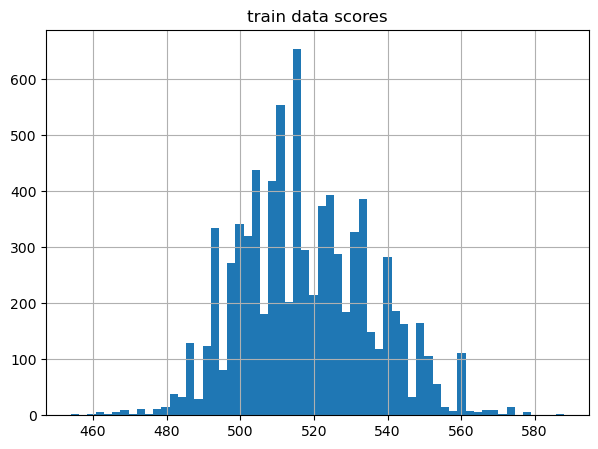

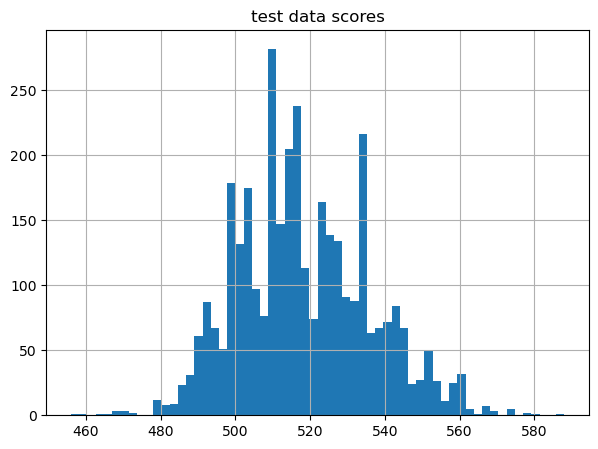

In [20]:
# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

# distrubution of scores on test data
train_score.hist(figsize=(7,5),bins=60)
plt.title('train data scores')
test_score.hist(figsize=(7,5),bins=60)
plt.title('test data scores')

In [21]:
# evaluation
y_pred = lr.predict(X_test)

print("Confusion matrix:")
print(confusion_matrix(y_pred, y_test))
print("\nPCC measures:")
print(classification_report(y_pred, y_test))

Confusion matrix:
[[1917  134]
 [1244  189]]

PCC measures:
              precision    recall  f1-score   support

           0       0.61      0.93      0.74      2051
           1       0.59      0.13      0.22      1433

    accuracy                           0.60      3484
   macro avg       0.60      0.53      0.48      3484
weighted avg       0.60      0.60      0.52      3484



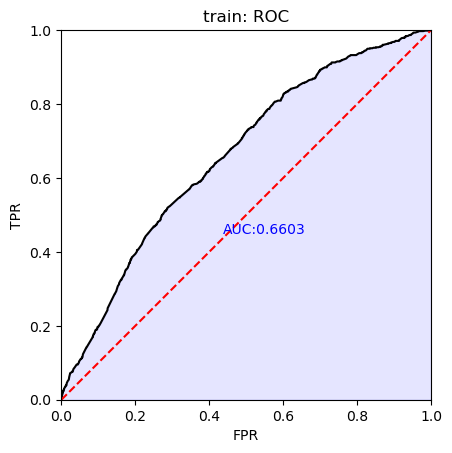

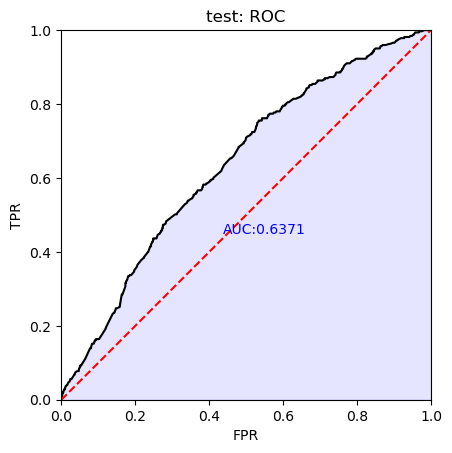

In [22]:
# evaluate the performance of the logistic regression
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# performance ks & roc
train_perf = sc.perf_eva(y_train, train_pred, plot_type=['roc'], title = "train")
test_perf = sc.perf_eva(y_test, test_pred, plot_type=['roc'], title = "test")